# Brown Dwarfs

Import some stuff:

In [1]:
%matplotlib inline

In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

import theano
import theano.tensor as tt
import theano.sparse as ts

In [3]:
starry.config.lazy = False
starry.config.quiet = True
np.random.seed(1)

## Generate

Generate a random light curve with `npts=1000` points over `tmax=100` days. To generate the light curve, I'm creating `nnodes=9` random surface maps and interpolating over them with a cubic spline to obtain a smooth, continuously changing surface map over the entire timeseries. The timescale is therefore something on the order of `100 / 9 ~ 11` days.

Each surface map is a random draw from a zero-mean isotropic Gaussian process on the sphere with a power spectrum characterized by the peak power `pmax=1e-2`, the scale at which it peaks `lmax=0.0`, and the scale at which it damps (the standard deviation of the Gaussian) `sig=3.0`. The "scale" is the spherical harmonic degree of the features. A peak at zero means that the `l = 0` spherical harmonic has the highest power (this is the baseline, background term). A standard deviation of `3.0` means that the power begins to drop quickly beyond `l = 3` or so. Typical features on the surface will therefore "look" like `l = 3` modes, which have a characteristic angular size of $180^\circ/3 = 60^\circ$ (with quite a bit of variance).

This is by far the simplest way to describe a surface. We can chat about encoding anisotropy -- i.e., features that prefer certain latitudes. It's trickier but definitely doable. The point in this notebook is to only recover the scale `sig` given a light curve; we can build from that as we go.

To generate the light curve, I assume the rotation period is `prot=3.347` days and the brown dwarf is seen at an inclination `inc=60` degrees.

In [4]:
def power(l, pmax, lmax, sig):
    """Return the power at a given spherical harmonic degree."""
    return pmax * np.exp(-0.5 * (l - lmax) ** 2 / sig ** 2)


def generate_light_curve(
    ydeg=10,
    inc=60,
    prot=3.347,
    pmax=1e-2,
    lmax=0.0,
    sig=3.0,
    nnodes=9,
    npts=1000,
    tmax=100,
    tpad=20,
):
    """
    Generate a synthetic light curve.
    
    """
    # Compute the (diagonal of the) covariance matrix
    cov = np.concatenate(
        [
            [power(l, pmax, lmax, sig) for m in range(-l, l + 1)]
            for l in range(1, ydeg + 1)
        ]
    )

    # The time array
    t = np.linspace(0, tmax, npts)

    # Draw one Ylm vector per node
    ynodes = np.hstack(
        [(np.random.randn(len(cov)) * np.sqrt(cov)).reshape(-1, 1) for n in range(nnodes)]
    )
    tnodes = np.linspace(-tpad, tmax + tpad, nnodes)

    # Interpolate between nodes to get the Ylm vector
    # as a function of time
    f = interp1d(tnodes, ynodes, axis=-1, kind="cubic")
    y = f(t)

    # Get the starry design matrix
    map = starry.Map(ydeg, inc=inc)
    A = map.design_matrix(theta=360.0 / prot * t)[:, 1:]

    # Compute the flux
    flux = 1.0 + np.diag(A @ y)

    return t, flux, y

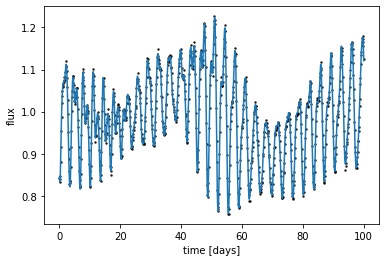

In [5]:
# Generate a random light curve
np.random.seed(0)
t, flux0, y = generate_light_curve()

# Add photon noise
ferr = 5e-3
flux = flux0 + ferr * np.random.randn(len(t))

plt.plot(t, flux, "k.", alpha=0.75, ms=3);
plt.plot(t, flux0, "C0-")
plt.xlabel("time [days]")
plt.ylabel("flux");

In [18]:
y

array([[ 0.01244596,  0.01150773,  0.01057232, ...,  0.02421427,
         0.02423561,  0.02425256],
       [-0.10185046, -0.10157108, -0.10128644, ..., -0.04587296,
        -0.04555465, -0.04523254],
       [ 0.01356501,  0.01297113,  0.0123797 , ...,  0.0893172 ,
         0.0895685 ,  0.08981567],
       ...,
       [-0.01159648, -0.01153832, -0.01147969, ..., -0.00438735,
        -0.00441038, -0.00443343],
       [ 0.00108981,  0.00102725,  0.00096476, ...,  0.01297622,
         0.01304629,  0.01311569],
       [ 0.00410667,  0.00410304,  0.00409945, ..., -0.00640057,
        -0.00646432, -0.00652768]])

I added some photon noise to make it more realistic. Note that the rotation period is clearly visible, and so is the slow evolution of features on the surface. Let's look at the corresponding movie of what the surface is doing:

In [6]:
# Generate a movie of the stellar surface
ydeg=10
map = starry.Map(ydeg)
res = 300
nframes = 100
movie = np.empty((nframes, res, res))

for i in tqdm(range(nframes)):
    k = int(i * len(t) / nframes)
    map[1:, :] = y[:, k]
    movie[i] = map.render(projection="rect", res=300)

  0%|          | 0/100 [00:00<?, ?it/s]

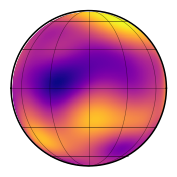

In [7]:
map.show(image=movie, projection="rect")
map.show(projection="ortho")

## Inference

Now let's try to infer the scale of features `sig` from the light curve. Let's assume we know the true values of the following parameters:

In [8]:
ydeg = 10
lmax = 0.0
pmax = 1e-2
prot = 3.347
inc = 60.0

We're going to fit the light curve with a spatio-temporal Gaussian process. We *should* fit for what the map looks like at every cadence, but that would be too many parameters. Instead, let's fit for the values at `30` nodes and interpolate between them. Note that this is more than the `9` nodes we used to generate the data, only to keep things interesting.

The next chunk computes the "design matrix" for the problem, the linear operator that converts from spherical harmonic coefficients to flux.

In [9]:
# Pre-compute the interpolation matrix (linear)
nnodes = 30
tnodes = np.linspace(t[0], t[-1], nnodes)
dt = tnodes[1] - tnodes[0]
diags = np.zeros((nnodes, len(t)))
for k in range(nnodes):
    w = 1 - np.abs(tnodes[k] - t) / dt
    w[w < 0] = 0
    diags[k] = w
I = np.hstack([np.diag(diag) for diag in diags])

# Pre-compute the starry design matrix
map = starry.Map(ydeg, inc=inc)
X = map.design_matrix(theta=360.0 / prot * t)[:, 1:]

# Combine to get the full design matrix
XL = block_diag(*[X for n in range(nnodes)])
A = I.dot(XL)

This function computes the covariance of our spatio-temporal Gaussian process. Its hyperparameters -- `sig` and `tau` are the things we're going to solve for. They correspond to the spatial and temporal scales of the Gaussian process, respectively. The former is the one we're really interested; the latter is interesting, too: in the case of a real brown dwarf, it's something like the timescale on which weather changes.

In [10]:
def get_cov(sig, tau):
    # The spatial GP cov
    Ls = np.diag(
        np.concatenate(
            [
                [power(l, pmax, lmax, sig) for m in range(-l, l + 1)]
                for l in range(1, ydeg + 1)
            ]
        )
    )

    # The temporal GP cov
    k = np.arange(nnodes).reshape(1, -1) - np.arange(nnodes).reshape(-1, 1)
    Lt = np.exp(-0.5 * (k * dt / tau) ** 2)

    # The full GP cov
    L = np.kron(Lt, Ls)
    L += 1e-12 * np.eye(L.shape[0])
    
    return L

Given a covariance matrix, it's easy to compute the *marginal likelihood*: the likelihood of the data given the model, marginalized (i.e., integrated) over all possible values of the spherical harmonic coefficients that are consistent with the dataset. Because everything is Gaussian, this integral is analytic, and only involves some (big) matrix inverses.

In [11]:
def get_lnlike(sig, tau):
    L = get_cov(sig, tau)
    lnlike = starry.linalg.lnlike(A, flux - 1.0, C=ferr**2, mu=0, L=L)
    return lnlike

Let's define a grid over `sig` and `tau`. We'll compute the marginal likelihood everywhere on this grid in a big for loop.

In [12]:
sig = np.linspace(2.0, 3.5, 20)
tau = np.linspace(12.5, 15.0, 20)

In [13]:
lnlike = np.zeros((len(sig), len(tau)))

for i in tqdm(range(len(sig)), desc="sig"):
    for j in tqdm(range(len(tau)), desc="tau", leave=False):
        lnlike[i, j] = get_lnlike(sig[i], tau[j])

sig:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

tau:   0%|          | 0/20 [00:00<?, ?it/s]

That took a while for me (about half an hour). There are ways to **really** speed this up (like, by 2 orders of magnitude) -- we should chat about them later.

Here's the plot of the marginal likelihood, where we can see right away that we got really close to the true spatial scale of `3.0`:

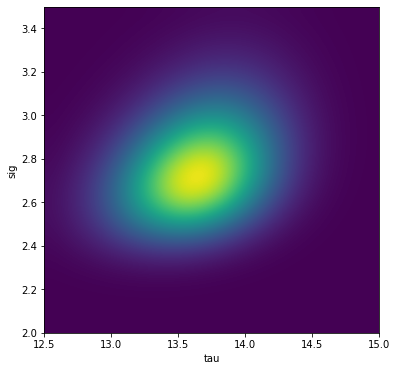

In [14]:
# Exponentiate to get the actual *likelihood* (normalized to unity)
like = np.exp(lnlike - np.max(lnlike))

plt.figure(figsize=(6, 6))
plt.imshow(
    like,
    origin="lower",
    extent=(np.min(tau), np.max(tau), np.min(sig), np.max(sig)),
    aspect="auto",
    interpolation="bicubic",
)
plt.xlabel("tau")
plt.ylabel("sig");

The temporal scale is about `13.5` days, which is close to the `11`ish days we assumed in the synthetic data. (We can chat about why these are different if you'd like -- I don't think it's going to be a problem for you).

The last thing we can do is marginalize one last time by integrating over `tau` to ask, "what is the likelihood of `sig`, regardless of the value of `tau`?" We do this by summing over the `tau` dimension in the plot above:

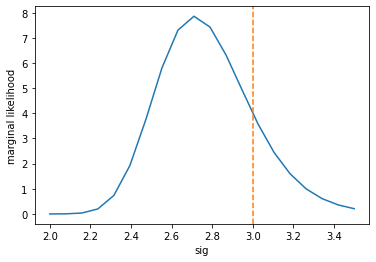

In [15]:
like_marg = np.sum(like, axis=1)
plt.plot(sig, like_marg)
plt.xlabel("sig")
plt.ylabel("marginal likelihood")
plt.axvline(3.0, color="C1", ls="--");

The dashed orange line is the true value: as you can tell, our results are fully consistent, within about one sigma!

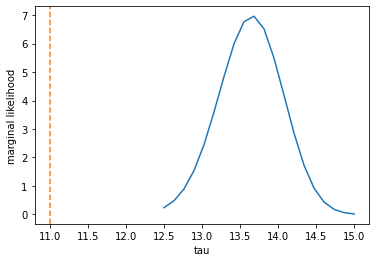

In [16]:
like_marg = np.sum(like, axis=0)
plt.plot(tau, like_marg)
plt.xlabel("tau")
plt.ylabel("marginal likelihood")
plt.axvline(11.0, color="C1", ls="--");